In [1]:
import numpy as np
import scipy
import xarray as xr
import cmocean as cmo
from numpy import linalg as LA
import matplotlib.pyplot as plt
from glob2 import glob

import datetime as dt

from tqdm import tqdm
from swath_rossby_wave import skill_matrix, build_h_matrix2, build_hswath_matrix2
from swath_rossby_wave import inversion, make_error_over_time, read_simulator_error, build_hswath_matrix2_for_simulator

In [47]:
# set standard deviation of error parameters
alpha_std = np.arange(5e-4, 3.05e-2, 1e-3)

day0_array = [0, 31, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
# choose month to use for this case study
# month_number=0
# day_start=day0_array[month_number]

In [3]:
# set basic parameters:  dates, longitude/latitude range
day0, day1 = 0, 40 # 
Tdim = day1 - day0
n_waves = '190' #number of waves
time_range = 2 * (day1 - day0) # assimilation + forecast window

MModes = 1 # Rossby wave vertical modes
wave_files = glob('./rossby_wave_estimate_*_' + n_waves + 'waves_swotdomain_40days.nc')
wave_files = sorted(wave_files)

lonidx_west, lonidx_east  =  74, 110
latidx_south, latidx_north = 25, 65

# read AVISO data and demean to obtain background mask
aviso_ds = xr.open_dataset('./aviso_msla_ccs_1d.nc')

SSHA = aviso_ds.msla[latidx_south:latidx_north,lonidx_west:lonidx_east, :]
# remove mean over full study period to produce anomaly.  
SSHA = SSHA-SSHA[:].mean(axis = -1)
# alternatively # remove 80-day mean  SSHA[day0 + day0 + 30].mean(axis = -1)

# read in data to get mask
SSHA_masked = np.ma.masked_invalid(SSHA)
ssha_mask = np.ma.getmask(SSHA_masked[:,:,day0:(day1-day0)*2])
lon, lat = (360 - aviso_ds.lon[lonidx_west:lonidx_east].data) * -1, aviso_ds.lat[latidx_south:latidx_north].data
T_time = aviso_ds.time.data[day0:] * 86400 # in seconds
date_time = aviso_ds.date_time.data[day0:]

# set background parameters for propagating Rossby wave model
Phi0 = lat.mean() # central latitude (φ0)
Omega = 7.27e-5 # Ω is the angular speed of the earth
Earth_radius = 6.371e6 / 1e5 # meters
Beta = 2 * Omega * np.cos(Phi0*np.pi/180.) / Earth_radius
f0 = 2 * Omega * np.sin(Phi0*np.pi/180.) #1.0313e-4 # 45 N

# noise and error scaling are hardwired but can be changed.
# R = 0.001 # noise = 3.1 cm
R = 0.01 # noise = 10. cm  ##default
# R = 0.1 # noise = 31. cm
# sigma_scale = 0.65 # scale so that RMS correlated error matches applied sigma (empirically derived)
sigma_scale = 1.00 # default
# sigma_scale = 0.3 # effective sigma smaller than RMS correlated error
# sigma_scale = 1.5 # effective sigma comparable to RMS correlated error

In [4]:
# list SWOT data files
# swot_files = sorted(glob('./SWOT_L2_LR_SSH_Expert_474*.nc'))

In [5]:
# read SWOT data files only to obtain bathymetry; keep ascending and descening passes separate
# will need to match coordinates between simulator default grid and SWOT grid by choosing an offset so that depth is meaningful
swot_files_a = sorted(glob('./SWOT_L2_LR_SSH_Expert_474_013*.nc'))
swot_files_d = sorted(glob('./SWOT_L2_LR_SSH_Expert_474_026*.nc'))
swot_ds_a = xr.open_mfdataset(swot_files_a, combine='nested', concat_dim = 'num_lines') # , engine='store', chunks={'time': 10})
swot_ds_d = xr.open_mfdataset(swot_files_d, combine='nested', concat_dim = 'num_lines') # , engine='store', chunks={'time': 10})

In [11]:
# Read swot_ds to identify SWOT data coordinates

# Extract the latitudes and longitudes within the swath
latitude_swot_a = swot_ds_a['latitude'].values
longitude_swot_a = swot_ds_a['longitude'].values-360
latitude_swot_d = swot_ds_d['latitude'].values
longitude_swot_d = swot_ds_d['longitude'].values-360

# read cross track distance, and depth
cross_track_swot_a = swot_ds_a['cross_track_distance'].values
depth_a=swot_ds_a['depth_or_elevation'].values
cross_track_swot_d = swot_ds_d['cross_track_distance'].values
depth_d=swot_ds_d['depth_or_elevation'].values

# use a brute-strength approach to separate ascending and descending tracks
direction_swot_a = np.sign(np.diff(latitude_swot_a,n=1,axis=0))
direction_swot_d = np.sign(np.diff(latitude_swot_d,n=1,axis=0))

# # to tightly distinguish ascending and descening, use time difference between reference tracks
# time_swot = swot_ds_a['time'].values
# time_hrs=time_swot[:].astype('datetime64[h]').astype(int)-466680
# direction_asc = np.all([time_hrs >5,time_hrs < 11],axis=0)
# direction_des = np.all([time_hrs >=11,time_hrs < 22],axis=0)

In [12]:
# read in simulator files needed to set mask
#simulator_files = sorted(glob('/home/sgille/swot_simulator/karin/2024/SWOT_L2_LR_SSH_Expert_001*.nc'))
#simulator_files = sorted(glob('/home/sgille/swot_simulator/karin/2016/SWOT_L2_LR_SSH_Expert_001_002_20160101*.nc'))
#simulator_files2 = sorted(glob('/home/sgille/swot_simulator/karin/2016/SWOT_L2_LR_SSH_Expert_001_017_20160101*.nc'))
simulator_files = sorted(glob('/home/sgille/swot_simulator/karin/2016/SWOT_L2_LR_SSH_Expert_001_002_20160101*.nc'))
simulator_files2 = sorted(glob('/home/sgille/swot_simulator/karin/2016/SWOT_L2_LR_SSH_Expert_001_017_20160101*.nc'))
simulator_ds = xr.open_mfdataset(simulator_files, combine='nested', concat_dim = 'num_lines') # , engine='store', chunks={'time': 10})
simulator_ds2 = xr.open_mfdataset(simulator_files2, combine='nested', concat_dim = 'num_lines') 

In [13]:
# read latitude/longitude information from simulator file
latitude_nadir = simulator_ds['latitude_nadir'].values
longitude_nadir = simulator_ds['longitude_nadir'].values-360
latitude1 = simulator_ds['latitude'].values   
longitude1 = simulator_ds['longitude'].values-360
cross_track1 = simulator_ds['cross_track_distance'].values
# here's a brute-strength approach to separate ascending and descending tracks
#   not used in this case, since ascending and descending are read separately
#direction1 = np.sign(np.diff(latitude1,n=1,axis=0))

latitude2 = simulator_ds2['latitude'].values   
longitude2 = simulator_ds2['longitude'].values-360
cross_track2 = simulator_ds2['cross_track_distance'].values
#direction2 = np.sign(np.diff(latitude,n=1,axis=0))

In [14]:
# for ascending tracks, set mask for points to be used
# this is a check to make sure that depths are matched correctly, so is not formally needed
mask_swot_a=np.zeros([latitude_swot_a.shape[0],latitude_swot_a.shape[1]])
deltax_swot_a=np.zeros([latitude_swot_a.shape[0],latitude_swot_a.shape[1]])

# chose cross-track positions
use2=[5, 13, 21, 29,39,47,55,63]
istart=6662-48

deltax_swot_a=cross_track_swot_a/1.e5 # distance in 100 km, relative to nadir
for i in range(istart,latitude_swot_a.shape[0]-1,16):
    for j in use2:
        if(latitude_swot_a[i,j]>=min(lat) and latitude_swot_a[i,j]<=max(lat) and depth_a[i,j]<=0 
           and longitude_swot_a[i,j]<=max(lon) and longitude_swot_a[i,j]>=min(lon)):
            #print(latitude_swot_a[i,j],i,j)
            mask_swot_a[i,j]=1
        
index_swot_a=np.where(mask_swot_a==1)

In [15]:
# for descending tracks, set mask for points to be used
# like the previous cell, this is a check to make sure that depths are matched correctly, so is not formally needed
mask_swot_d=np.zeros([latitude_swot_d.shape[0],latitude_swot_d.shape[1]])
deltax_swot_d=np.zeros([latitude_swot_d.shape[0],latitude_swot_d.shape[1]])

# chose cross-track positions
use2=[5, 13, 21, 29,39,47,55,63]
istart=2570

deltax_swot_d=cross_track_swot_d/1.e5 # distance in 100 km, relative to nadir
for i in range(istart,latitude_swot_d.shape[0]-1,16):
    for j in use2:
        if(latitude_swot_d[i,j]>=min(lat) and latitude_swot_d[i,j]<=max(lat) and depth_d[i,j]<=0 
           and longitude_swot_d[i,j]<=max(lon) and longitude_swot_d[i,j]>=min(lon)):
            #print(latitude_swot[i,j],i,j)
            mask_swot_d[i,j]=1  

index_swot_d=np.where(mask_swot_d==1)

In [16]:
# now using simulator grid, identify points to use within swath and remove swath points that won't be used
mask=np.zeros([latitude1.shape[0],latitude1.shape[1]])
deltax1=np.zeros([latitude1.shape[0],latitude1.shape[1]])
asc_des1=np.zeros([latitude1.shape[0],latitude1.shape[1]]) #descending
mask2=np.zeros([latitude2.shape[0],latitude2.shape[1]])
deltax2=np.zeros([latitude2.shape[0],latitude2.shape[1]])
asc_des2=np.ones([latitude2.shape[0],latitude2.shape[1]])  #ascending

# chose cross-track positions
use2=[6, 14, 22, 30,32,40,48,56]
use_swot=[5, 13, 21, 29,39,47,55,63]

deltax1=cross_track1/1.e5 # distance in 100 km, relative to nadir
ioffset=2570
for i in range(0,latitude1.shape[0]-1,16):
    for j in range(0,len(use2)):
        jsim=use2[j]
        jswot=use_swot[j]
        if(latitude1[i,jsim]>=min(lat) and latitude1[i,jsim]<=max(lat) and depth_d[i+ioffset,jswot]<=0 
           and longitude1[i,jsim]<=max(lon) and longitude1[i,jsim]>=min(lon)):
            mask[i,jsim]=1
        
deltax2=cross_track2/1.e5 # distance in 100 km, relative to nadir
ioffset=6662-48
for i in range(0,latitude2.shape[0]-1,16):
    for j in range(0,len(use2)):
        jsim=use2[j]
        jswot=use_swot[j]
        if(latitude2[i,jsim]>=min(lat) and latitude2[i,jsim]<=max(lat) and depth_a[i+ioffset,jswot]<=0 
           and longitude2[i,jsim]<=max(lon) and longitude2[i,jsim]>=min(lon)):
            mask2[i,jsim]=1
            
index=np.where(mask==1)  #descending
index2=np.where(mask2==1)  #ascending

In [17]:
# prepare a mask for in-swath vs out-of-swath data
mask_asc=np.zeros([len(lat),len(lon)])
mask_des=np.zeros([len(lat),len(lon)])
mask_total=np.zeros([len(lat),len(lon)])

#ascending bounds
y1=latitude2[:,6]
x1=longitude2[:,6]
y2=latitude2[:,56]
x2=longitude2[:,56]
lon_edge1=np.interp(lat,y1,x1)
lon_edge2=np.interp(lat,y2,x2)

#descending bounds
y1=latitude1[:,6]
x1=longitude1[:,6]
y2=latitude1[:,56]
x2=longitude1[:,56]
lon_edge3=np.interp(lat,np.flip(y1),np.flip(x1))
lon_edge4=np.interp(lat,np.flip(y2),np.flip(x2))
for i in range(len(lat)):
    for j in range(len(lon)):
        if(lon[j]>=lon_edge1[i] and lon[j]<=lon_edge2[i]):
            mask_asc[i,j]=1
        if(lon[j]<=lon_edge3[i] and lon[j]>=lon_edge4[i]):  # descending order reversed
            mask_des[i,j]=1.  
        if(mask_asc[i,j]==1 or mask_des[i,j]==1):
            mask_total[i,j]=1 

In [18]:
latitude=np.concatenate((latitude1[index],latitude2[index2]))  #descending then ascending
longitude=np.concatenate((longitude1[index],longitude2[index2]))  #descending then ascending
deltax=np.concatenate((deltax1[index],deltax2[index2]))  #descending then ascending
asc_des=np.concatenate((asc_des1[index],asc_des2[index2]))  #descending then ascending

In [107]:
# Arrays to store variance explained
nsigma=2  ## number of error data sets and covariance matrices to be tested
nfiles=len(wave_files)
variance_explained_1step = np.zeros([nfiles, nsigma, time_range])
variance_explained_in_1step = np.zeros([nfiles, nsigma, time_range])
variance_explained_out_1step = np.zeros([nfiles, nsigma, time_range])
variance_explained_2step = np.zeros([nfiles, nsigma, time_range])
variance_explained_in_2step = np.zeros([nfiles, nsigma, time_range])
variance_explained_out_2step = np.zeros([nfiles, nsigma, time_range])
variance_explained_2stepa = np.zeros([nfiles, nsigma, time_range])
variance_explained_in_2stepa = np.zeros([nfiles, nsigma, time_range])
variance_explained_out_2stepa = np.zeros([nfiles, nsigma, time_range])
variance_explained_in_persistence = np.zeros([nfiles, nsigma, time_range])
variance_explained_out_persistence = np.zeros([nfiles, nsigma, time_range])
variance_explained_persistence = np.zeros([nfiles, nsigma, time_range])

In [20]:
# define stratification for Rossby wave model
strat_ds = xr.open_dataset('./stratification_sample_ccs.nc')
Psi = strat_ds.Psi.data

# set longitude and latitude anomalies relative to mean
dlon = lon - lon.mean()
dlat = lat - lat.mean()

# pre-fill output arrays with zeros
rms_err, rms_ssh = np.zeros([len(wave_files), len(alpha_std)]), np.zeros([len(wave_files), len(alpha_std)])
rms_err2, rms_ssh2 = np.zeros([len(wave_files), len(alpha_std)]), np.zeros([len(wave_files), len(alpha_std)])

ssh_est_skill2, err_est_skill2 = np.zeros([len(wave_files), len(alpha_std)]), np.zeros([len(wave_files), len(alpha_std)])
ssh_est_skill2a, err_est_skill2a = np.zeros([len(wave_files), len(alpha_std)]), np.zeros([len(wave_files), len(alpha_std)])

ssh_est_skill1, err_est_skill1 = np.zeros([len(wave_files), len(alpha_std)]), np.zeros([len(wave_files), len(alpha_std)])

total_est_skill1, total_est_skill2 = np.zeros([len(wave_files), len(alpha_std)]), np.zeros([len(wave_files), len(alpha_std)])
total_est_skill2a = np.zeros([len(wave_files), len(alpha_std)])

err_proj_err, ssh_proj_err = np.zeros([len(wave_files), len(alpha_std)]), np.zeros([len(wave_files), len(alpha_std)])
err_proj_err2, ssh_proj_err2 = np.zeros([len(wave_files), len(alpha_std)]), np.zeros([len(wave_files), len(alpha_std)])
noise_proj_err, noise_proj_err2 = np.zeros([len(wave_files), len(alpha_std)]), np.zeros([len(wave_files), len(alpha_std)])

In [21]:
# read in first file and configure basic matrix information
n=0
ndays=day1-day0

wave_ds = xr.open_dataset(wave_files[n]) # forward model - filtered AVISO
l_n_orig, k_n_orig = wave_ds.l_n.data, wave_ds.k_n.data
amp = wave_ds.Amplitudes.data
time= wave_ds.time.data
MSLA_fwd = wave_ds.MSLA_forward.data
MSLA_fwd = np.ma.masked_where(ssha_mask,MSLA_fwd)

Rm = wave_ds.Rm.data # Rossby deformation radius, unit: degree

l_n = l_n_orig.reshape(len(l_n_orig), MModes)
k_n = k_n_orig.reshape(len(k_n_orig), MModes)

MSLA0 = MSLA_fwd[:, :, day0:day1]

### assess skill, get indices
# note that this measure of skill is not used subsequently
# code was written this way to test fraction of variance explained by each wavenumber combination
skill, SSHA_vector, Iindex, Jindex, Tindex = skill_matrix(MSLA0, Psi, k_n, l_n, MModes, Rm, lon, lat, T_time) # skill marrix

M = k_n.size * l_n.size # Number of models/waves

# define matrix inversion, accounting for land gaps
# matrix H_all is consistent for all start dates
H_all, SSHA_vector = build_h_matrix2(MSLA0, MModes, k_n, l_n, lon, lat, T_time[:], Psi, Rm, day0-day0)

# create a dummy masked matrix in order to build the full H matrix
ssha_clean = np.ma.masked_invalid(np.zeros([MSLA0.shape[0],MSLA0.shape[1],MSLA0.shape[2]]))

# create full matrices, no land gaps, to faciliate projection
# matrices are consistent for all start dates
H_all_full_grid, SSHA_vector_full = build_h_matrix2(ssha_clean, MModes, k_n, l_n, lon, lat, T_time[:], Psi, Rm, day0-day0)
H_all_full_grid2, SSH_vector2_full = build_h_matrix2(ssha_clean, MModes, k_n, l_n, lon, lat, T_time, Psi, Rm, ndays)

In [22]:
ssh_reconstructed=np.matmul(H_all_full_grid, amp)

In [23]:
# define an H matrix for swath points only
H_swath = build_hswath_matrix2_for_simulator(ssha_clean, MModes, k_n, l_n, lon,lat,longitude, latitude, index, T_time, Psi, Rm, day0-day0)

In [24]:
# set indices for correlated error, by counting backwards
IND_TIMING = -7 
IND_ROLL = -6
IND_BASELINE = -5
IND_PHASE3, IND_PHASE4, IND_PHASE5, IND_PHASE6 = -4, -3, -2, -1

In [36]:
# define H matrix for correlated error terms
Valid_points = len(latitude) 
err_basis_func = np.zeros([Valid_points, 2, 7])
H_swath_roll = np.zeros([Tdim*Valid_points,Tdim*14])

tt=0
for ii in range(len(latitude)):
    iasc=int(asc_des[ii])
    #timing error
    err_basis_func[ii, iasc, IND_TIMING] = 1 #  alpha_timing, TIMING ERR, distance from nadir Xc
    # roll error = alpha[1] * Xc^1
    err_basis_func[ii, iasc, IND_ROLL] = deltax[ii]  # alpha_roll, ROLL ERR, distance from nadir Xc
    # baseline dialation error = alpha[2] * Xc^2
    err_basis_func[ii, iasc, IND_BASELINE] = deltax[ii]**2  # alpha_base, BASELINE DIALATION ERR, distance from nadir Xc 
    # phase error 
    H_neg = np.heaviside(-1 * deltax[ii], 1) #
    H_pos = np.heaviside(deltax[ii], 1) # 
    err_basis_func[ii, iasc, IND_PHASE3] = H_neg                 # alpha_phase3 * np.heaviside(xx - xc, 1)
    err_basis_func[ii, iasc, IND_PHASE4] = deltax[ii] * H_neg # alpha_phase4 * Xc * np.heaviside(xx - xc, 1)
    err_basis_func[ii, iasc, IND_PHASE5] = H_pos                 # alpha_phase5 * np.heaviside(xx + xc, 1)
    err_basis_func[ii, iasc, IND_PHASE6] = deltax[ii] * H_pos # alpha_phase6 * np.heaviside(xx + xc, 1)
 
err_basis_func=err_basis_func.reshape([Valid_points, 14])
    
for tt in range(Tdim):
    H_swath_roll[tt*Valid_points:(tt+1)*Valid_points, tt * 14 : (tt+1) * 14] = err_basis_func

In [38]:
# build total H matrix for in-swath data by concatenating Rossby wave and correlated error matrices
H_swath_total = np.concatenate((H_swath, H_swath_roll),axis=1)

In [39]:
# diagnostic:  reconstruct "true" data on swath
map_swath=np.matmul(H_swath,amp)

In [40]:
# set time duration 
Tdim=day1-day0

In [41]:
#  build covariance matrix:  R over P

counter = 0
exp = -2
ssh_std = .1
k0 = k_n.max() # flat at or below k0 

M = l_n.size * k_n.size
p_diagonal = np.zeros([2 * M])
kl, kl_plot = np.zeros(M), np.zeros(2*M)
k_, l_ = np.zeros(len(k_n)*len(l_n)), np.zeros(len(k_n)*len(l_n))
counter = 0

for kk in k_n:
    for ll in l_n:
        k_[counter] = kk 
        l_[counter]  = ll
        kl[counter] =  np.sqrt(kk ** 2 + ll ** 2) # wavenumber
        kl_plot[2 * counter], kl_plot[2 * counter + 1] = kl[counter], kl[counter]
        p_diagonal[2 * counter] = (kl[counter]+k0) ** exp 
        p_diagonal[2 * counter + 1] = (kl[counter]+k0) ** exp 
        counter += 1   

R_over_P = np.zeros([2 * M, 2 * M])
p_factor = .16/p_diagonal.sum() # variance of the model,  convert sum of variance from waven number to meter
np.fill_diagonal(R_over_P[:],  R / p_diagonal / p_factor)

/tmp/ipykernel_3862113/3421246840.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k_[counter] = kk
/tmp/ipykernel_3862113/3421246840.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  l_[counter]  = ll
/tmp/ipykernel_3862113/3421246840.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kl[counter] =  np.sqrt(kk ** 2 + ll ** 2) # wavenumber


In [42]:
# redo R_over_P adding in covariance for roll error; this will change with each assumed roll error uncertainty
sigma=0.2  ## temporary value to set up matrix
p_diagonal = np.diagonal(R_over_P)
p_diagonal_roll = np.zeros([Tdim * 7*2])
p_diagonal_roll[:] = R/sigma ** 2 
R_over_P_total = np.zeros([len(p_diagonal)+len(p_diagonal_roll),len(p_diagonal)+len(p_diagonal_roll)])

np.fill_diagonal(R_over_P_total[:],  np.concatenate((p_diagonal,p_diagonal_roll)))

In [43]:
# Two-stage approach: reconstructing the SSH separately from solving the correlated error

# First step: fit errors
H_v1 = H_swath_total[:, -7 *2* Tdim:]
R_over_P1 = R_over_P_total[-7*2* Tdim:, -7*2* Tdim:]
HTH = np.matmul(H_v1.T, H_v1)
HRH = HTH + R_over_P1 # P: uncertainty in model, R: uncertainty in data
D1 = np.matmul(LA.inv(HRH), H_v1.T)

In [44]:
# second step: fit residual to rossby wave models

H_v = H_swath_total[:, :-7 *2* Tdim]
HTH = np.matmul(H_v.T, H_v)
HRH = np.zeros(HTH.shape)
HRH = HTH +  R_over_P_total[:-7 *2* Tdim, :-7 *2* Tdim]  # !!!  move into loop
D2 = np.matmul(LA.inv(HRH), H_v.T)

In [108]:
# now loop through all files
p_diagonal_roll_augmented = np.zeros([Tdim * 7*2])
iref=20 # reference time step for persistence
with tqdm(total= rms_err[:,0].size) as pbar:
    for n in range(len(wave_files)):
        wave_ds = xr.open_dataset(wave_files[n]) # forward model - filtered AVISO
        MSLA_fwd = wave_ds.MSLA_forward.data
        MSLA_fwd = np.ma.masked_where(ssha_mask,MSLA_fwd)
        temp=MSLA_fwd[:,:,:40].transpose([2,0,1])
        MSLA_vector=np.ma.compressed(temp.flatten())
 
        amp_recovered, ssh_estimated = inversion(MSLA_vector, H_all, R_over_P)
        
        # map "true" data on swath
        amp = wave_ds.Amplitudes.data
        ssh=np.matmul(H_swath,amp)
        N=len(ssh)
        
        # read correlated error
        day_start = day0_array[n]
        print(day_start+1,day1-day0)
        cor_err, stats_output = read_simulator_error(day_start+1,day1-day0,index,index2)        
    
        # Loop over sigma
        sigma_counter = 0
        
        for sigma in range(nsigma): # std of error amp  ### choose a single value for simulator analysis

            # Add errors to the swaths
            R = 0.01  # assumed measurement error ~ 10 cm noise
            # sigma_use = 0.3 # set large initial uncertainty due to large roll error
            if(sigma==0):
                sigma_use = alpha_std[12]
            # sigma_use=[0.001,0.001,0.15,0.015,0.3,0.015,0.3] # BASELINE, reweight to remove downweight terms that make this rank deficient
            if(sigma==1):
                sigma_use=[0.015,0.3,0.15,0.015,0.3,0.015,0.3]  ### case identified in stored output as "sigmavariable"
                sigma_use=np.tile(sigma_use,80)
            time_factor = np.arange(1, 1 + day1-day0)
            
            np.random.seed(10000000+n*len(alpha_std)+sigma_counter)# optional:  use random number seed to support reproducibility
            noise = np.random.normal(0.,0.02,N)
            
            input_swath = ssh +cor_err.reshape([len(map_swath)])

            p_diagonal_roll[:] = R/(sigma_use*sigma_scale) ** 2 # errors---scale to make prior error match inserted variance
            R_over_P_total = np.zeros([2 * M + Tdim * 7*2, 2 * M +  Tdim * 7*2])           
            np.fill_diagonal(R_over_P_total[:],  np.concatenate((p_diagonal,p_diagonal_roll)) )
            
            # 1-stage approach, solve for amplitudes            
            amp_1step, ssh_estimated_swath = inversion(input_swath, H_swath_total, R_over_P_total)

            # now use 1-stage approach amplitudes to map data onto AVISO grid
            MSLA_fwrd=np.matmul(H_all_full_grid, amp_1step[:H_all_full_grid.shape[1]])
            MSLA_fwrd=MSLA_fwrd.reshape([ndays,MSLA0.shape[0],MSLA0.shape[1]])
            MSLA_fwrd=MSLA_fwrd.transpose((1,2,0))
            MSLA_fwrd = np.ma.masked_where(np.ma.getmask(MSLA0),MSLA_fwrd)
    
            MSLA_fwrd2=np.matmul(H_all_full_grid2, amp_1step[:H_all_full_grid.shape[1]])
            MSLA_fwrd2=MSLA_fwrd2.reshape([ndays,MSLA0.shape[0],MSLA0.shape[1]])
            MSLA_fwrd2=MSLA_fwrd2.transpose((1,2,0))
            MSLA_fwrd2 = np.ma.masked_where(np.ma.getmask(MSLA0),MSLA_fwrd2)
            MSLA_fwrd_1step = np.concatenate((MSLA_fwrd,MSLA_fwrd2),axis=2)
    
            # 1-stage approach, solve for amplitudes

            # within the swath, estimate the errors and ssh : H * amp
            err_est_1step = np.matmul(H_swath_total[:, -7*2*Tdim:], amp_1step[-7*2*Tdim:])
            ssh_est_1step = np.matmul(H_swath_total[:, :-7*2*Tdim], amp_1step[:-7*2*Tdim])

            # Important result: error estimate skill and ssh estimate skill of the entire time series
            ssh_diff = ssh_est_1step - ssh
            err_diff = err_est_1step - cor_err
            ssh_diff1 = (np.mean(ssh_diff**2)) / (np.var(ssh))
            err_diff1  = (np.mean(err_diff**2)) / (np.var(cor_err))
            total_diff1 = np.mean((err_diff+ssh_diff)**2) / (np.var(input_swath))
            
            # Two-stage approach: reconstructing the SSH separately from solving the correlated error
            #  First step: fit errors; R over P matrix varies in time, so need to recompute
            H_v1 = H_swath_total[:, -7 *2* Tdim:]
            R_over_P1 = R_over_P_total[-7*2* Tdim:, -7*2* Tdim:]
            HTH = np.matmul(H_v1.T, H_v1)
            HRH = HTH + R_over_P1 # P: uncertainty in model, R: uncertainty in data
            D = np.matmul(LA.inv(HRH), H_v1.T)
            amp_err = np.matmul(D, input_swath)
            error_projection = np.matmul(D,cor_err)
            signal_projection = np.matmul(D,ssh)
            noise_projection = np.matmul(D,noise)
            
            # correlated errors have different R over P with time,, so recompute
            err_est_2step = np.matmul(H_v1, amp_err) #### estimate the correlated error
            err_est_proj = np.matmul(H_v1, error_projection) #### estimate the correlated error
            ssh_est_proj = np.matmul(H_v1, signal_projection) #### estimate the correlated error
            noise_est_proj = np.matmul(H_v1, noise_projection) #### estimate the correlated error
            
            # second step: fit residual to rossby wave models
            # matrix does not vary, so skip recomputing
            tau_ssh = input_swath - err_est_2step
            amp_swath_2step = np.matmul(D2, tau_ssh)
            amp_err_projection = np.matmul(D2, cor_err.reshape([len(map_swath)]))
            amp_ssh_projection = np.matmul(D2, ssh)
            amp_noise_projection = np.matmul(D2, noise)
            ssh_est_2step = np.matmul(H_v, amp_swath_2step) #### Reconstruct ssh with new amplitudes in the next 40 days
            ssh_err_projection = np.matmul(H_v, amp_err_projection) #### project noise onto Rossby waves
            ssh_signal_projection = np.matmul(H_v, amp_ssh_projection) #### project signal onto Rossby wavess
            ssh_noise_projection = np.matmul(H_v, amp_noise_projection) #### project signal onto Rossby wavess
            
            # Important result: 2-stage error estimate skill and ssh estimate skill relative to swath data
            ssh_diff = ssh_est_2step - ssh
            err_diff = err_est_2step - cor_err.reshape([len(map_swath)])
            #err_err_diff = err_est_proj - cor_err.reshape([len(map_swath)])
            #err_err_diff2 = ssh_err_projection - cor_err.reshape([len(map_swath)])
            #err_err_diff3 = ssh_err_projection - ssh
            #ssh_ssh_diff = ssh_est_proj - ssh
            #ssh_ssh_diff2 = ssh_signal_projection - ssh
            ssh_diff_2stage = (np.mean(ssh_diff ** 2)) / (np.var(ssh))
            err_diff_2stage = (np.mean(err_diff ** 2)) / (np.var(cor_err))
            #ssh_diff_err_proj = (np.mean(ssh_ssh_diff ** 2)) / (np.var(ssh))
            ssh_diff_err_proj = (np.var(ssh_est_proj)) / (np.var(ssh))
            #err_diff_err_proj = (np.mean(err_err_diff ** 2)) / (np.var(cor_err))
            err_diff_err_proj = (np.var(err_est_proj)) / (np.var(cor_err))
            #ssh_diff_err_proj2 = (np.mean(ssh_ssh_diff2 ** 2)) / (np.var(ssh))
            ssh_diff_err_proj2 = (np.var(ssh_signal_projection)) / (np.var(ssh))
            #err_diff_err_proj2 = (np.mean(err_err_diff2 ** 2)) / (np.var(cor_err))
            err_diff_err_proj2 = (np.var(ssh_err_projection)) / (np.var(cor_err))
            noise_diff_err_proj = (np.var(noise_est_proj)) / (np.var(noise))
            noise_diff_err_proj2 = (np.var(ssh_noise_projection)) / (np.var(noise))
            total_diff_2stage = np.mean((err_diff+ssh_diff)**2) / (np.var(input_swath))
            
            # Augmented two-stage approach: reconstructing the SSH separately from solving the correlated error
            #  First step: fit errors; R over P matrix same as before
            #  Second step:  fit residual using matrix for one-stage approach, with uncertainties reduced by an order of magnitude
            # sigma_use2 = 0.01 # after initial fit, allow for fine tuning of coefficients
            # sigma_use2=[0.007,0.3,0.07,0.007,0.3,0.007,0.3]
            # sigma_use2=[0.015,0.3,0.15,0.015,0.15,0.015,0.15]  #baseline, based on standard deviation of initial fit
            # sigma_use2=[0.007,0.4,0.2,0.007,0.4,0.007,0.4]
            # sigma_use2=[0.001,0.001,0.15,0.007,0.4,0.007,0.4]  # downweight terms responsible for rank deficiency
            # sigma_use2=[0.00001,0.00001,0.02,0.002,0.02,0.002,0.02]  # downweight terms responsible for rank deficiency, CASE 1
            # sigma_use2=[0.003,0.006,0.015,0.0015,0.015,0.0015,0.015]
            # sigma_use2=[0.015,0.3,0.15,0.007,0.15,0.007,0.15]  #baseline, based on standard deviation of initial fit, but less uncertainty
            # sigma_use2=np.tile(sigma_use2,80)
            sigma_use2=sigma_use
            # R2=R/4.
            # R2=1.
            R2=R
            # R2=R/10.
            # R2=R/100.
            p_diagonal_roll_augmented[:] = R2/(sigma_use2*sigma_scale) ** 2 # errors---scale to make prior error match inserted variance
            R_over_P_total_augmented = np.zeros([2 * M + Tdim * 7*2, 2 * M +  Tdim * 7*2])           
            np.fill_diagonal(R_over_P_total_augmented[:],  np.concatenate((p_diagonal,p_diagonal_roll_augmented)) )           
            amp_2step_augmented, ssh_estimated_swath_aug = inversion(tau_ssh, H_swath_total, R_over_P_total_augmented)  
            # amp_2step_augmented, ssh_estimated_swath_aug = inversion(input_swath, H_swath_total, R_over_P_total_augmented)  
            swath_two_stage_augmented = np.matmul(H_v, amp_2step_augmented[:H_all_full_grid.shape[1]])
            err_swath_two_stage_augmented = np.matmul(H_swath_roll, amp_2step_augmented[H_all_full_grid.shape[1]:])

            # now use augmented 2-stage amplitudes to map data onto AVISO grid
            MSLA_fwrd_2stepa=np.matmul(H_all_full_grid, amp_2step_augmented[:H_all_full_grid.shape[1]])
            MSLA_fwrd_2stepa=MSLA_fwrd_2stepa.reshape([ndays,MSLA0.shape[0],MSLA0.shape[1]])
            MSLA_fwrd_2stepa=MSLA_fwrd_2stepa.transpose((1,2,0))
            MSLA_fwrd_2stepa = np.ma.masked_where(np.ma.getmask(MSLA0),MSLA_fwrd_2stepa)
    
            MSLA_fwrd2_2stepa=np.matmul(H_all_full_grid2, amp_2step_augmented[:H_all_full_grid.shape[1]])
            MSLA_fwrd2_2stepa=MSLA_fwrd2_2stepa.reshape([ndays,MSLA0.shape[0],MSLA0.shape[1]])
            MSLA_fwrd2_2stepa=MSLA_fwrd2_2stepa.transpose((1,2,0))
            MSLA_fwrd2_2stepa = np.ma.masked_where(np.ma.getmask(MSLA0),MSLA_fwrd2_2stepa)
            MSLA_fwrd_2stepa = np.concatenate((MSLA_fwrd_2stepa,MSLA_fwrd2_2stepa),axis=2) 
            
            # Important result: error estimate skill and ssh estimate skill of the entire time series
            ssh_diff_2stepa = swath_two_stage_augmented - ssh
            err_diff_2stepa = err_swath_two_stage_augmented + err_est_2step - cor_err
            ssh_diff1_2stepa = (np.mean(ssh_diff_2stepa**2)) / (np.var(ssh))
            err_diff1_2stepa  = (np.mean(err_diff_2stepa**2)) / (np.var(cor_err))
            total_diff1_2stepa = np.mean((err_diff_2stepa+ssh_diff_2stepa)**2) / (np.var(input_swath))
            total_diff1_2stepa_alt = np.mean((ssh_estimated_swath_aug - tau_ssh)**2) / (np.var(input_swath))
            
            # Root mean squared err/ssh
            rms_err[n, sigma_counter] = np.sqrt(np.mean(cor_err ** 2))
            rms_ssh[n, sigma_counter]= np.sqrt(np.mean(ssh ** 2))
            rms_err2[n, sigma_counter] = np.std(cor_err)
            rms_ssh2[n, sigma_counter]= np.std(ssh)

            # Important result: 2-stage error estimate skill and ssh estimate skill
            ssh_est_skill2[n, sigma_counter], err_est_skill2[n, sigma_counter] = (1 - ssh_diff_2stage.mean()) * 100, (1 - err_diff_2stage.mean()) * 100 # percentage,
            total_est_skill2[n, sigma_counter] = (1 - total_diff_2stage.mean()) * 100
            err_proj_err[n, sigma_counter], ssh_proj_err[n, sigma_counter] = (err_diff_err_proj.mean()) * 100, (ssh_diff_err_proj.mean()) * 100 # percentage,
            err_proj_err2[n, sigma_counter], ssh_proj_err2[n, sigma_counter] = (err_diff_err_proj2.mean()) * 100, (ssh_diff_err_proj2.mean()) * 100 # percentage,
            noise_proj_err[n, sigma_counter], noise_proj_err2[n, sigma_counter] = (noise_diff_err_proj.mean()) * 100, (noise_diff_err_proj2.mean()) * 100 # percentage,            #err_proj_err[n, sigma_counter], ssh_proj_err[n, sigma_counter] = (1 - err_diff_err_proj.mean()) * 100, (1 - ssh_diff_err_proj.mean()) * 100 # percentage,
            #err_proj_err2[n, sigma_counter], ssh_proj_err2[n, sigma_counter] = (1 - err_diff_err_proj2.mean()) * 100, (1 - ssh_diff_err_proj2.mean()) * 100 # percentage,
                        
            # Important result: 1-stage error estimate skill and ssh estimate skill
            ssh_est_skill1[n, sigma_counter], err_est_skill1[n, sigma_counter] = (1 - ssh_diff1.mean()) * 100, (1 - err_diff1.mean()) * 100 # percentage,
            total_est_skill1[n, sigma_counter] = (1 - total_diff1.mean()) * 100
            
            # Important result: augmented 2-stage error estimate skill and ssh estimate skill
            ssh_est_skill2a[n, sigma_counter], err_est_skill2a[n, sigma_counter] = (1 - ssh_diff1_2stepa.mean()) * 100, (1 - err_diff1_2stepa.mean()) * 100 # percentage,
            total_est_skill2a[n, sigma_counter] = (1 - total_diff1_2stepa.mean()) * 100
            
            # now use 2-stage approach amplitudes to map data onto AVISO grid
            MSLA_fwrd=np.matmul(H_all_full_grid, amp_swath_2step)
            MSLA_fwrd=MSLA_fwrd.reshape([ndays,MSLA0.shape[0],MSLA0.shape[1]])
            MSLA_fwrd=MSLA_fwrd.transpose((1,2,0))
            MSLA_fwrd = np.ma.masked_where(np.ma.getmask(MSLA0),MSLA_fwrd)
    
            MSLA_fwrd2=np.matmul(H_all_full_grid2, amp_swath_2step)
            MSLA_fwrd2=MSLA_fwrd2.reshape([ndays,MSLA0.shape[0],MSLA0.shape[1]])
            MSLA_fwrd2=MSLA_fwrd2.transpose((1,2,0))
            MSLA_fwrd2 = np.ma.masked_where(np.ma.getmask(MSLA0),MSLA_fwrd2)
            MSLA_fwrd_2step = np.concatenate((MSLA_fwrd,MSLA_fwrd2),axis=2)
            
            for i in range(time_range):
                # Masking the in-track and out-of-track data
                msla_in = np.ma.masked_where(mask_total[:, :] == 0, MSLA_fwd[:, :, i])
                msla_out = np.ma.masked_where(mask_total[:, :] == 1, MSLA_fwd[:, :, i])

                # Apply the same mask to the predicted data
                msla_fwrd_in_1step = np.ma.masked_where(mask_total[:, :] == 0, MSLA_fwrd_1step[:, :, i])
                msla_fwrd_out_1step = np.ma.masked_where(mask_total[:, :] == 1, MSLA_fwrd_1step[:, :, i])
                msla_fwrd_in_2step = np.ma.masked_where(mask_total[:, :] == 0, MSLA_fwrd_2step[:, :, i])
                msla_fwrd_out_2step = np.ma.masked_where(mask_total[:, :] == 1, MSLA_fwrd_2step[:, :, i])
                msla_fwrd_in_2stepa = np.ma.masked_where(mask_total[:, :] == 0, MSLA_fwrd_2stepa[:, :, i])
                msla_fwrd_out_2stepa = np.ma.masked_where(mask_total[:, :] == 1, MSLA_fwrd_2stepa[:, :, i])
                
                # Variance of original data for in-swath and out-of-swath
                original_var_in = np.var(msla_in)
                original_var_out = np.var(msla_out)

                # Variance of predictions for in-swath and out-of-swath (1-step)
                predicted_var_in_1step = np.var(msla_fwrd_in_1step)
                predicted_var_out_1step = np.var(msla_fwrd_out_1step)

                # Variance of predictions for in-swath and out-of-swath (2-step)
                predicted_var_in_2step = np.var(msla_fwrd_in_2step)
                predicted_var_out_2step = np.var(msla_fwrd_out_2step)

                # Variance of predictions for in-swath and out-of-swath (2-step)
                predicted_var_in_2stepa = np.var(msla_fwrd_in_2stepa)
                predicted_var_out_2stepa = np.var(msla_fwrd_out_2stepa)
                
                # Variance explained (1-step)
                variance_explained_1step[n,sigma_counter,i] = np.mean((MSLA_fwd[:,:,i] - MSLA_fwrd_1step[:,:,i])**2) / np.var(MSLA_fwd[:,:,i])
                variance_explained_in_1step[n,sigma_counter,i] = np.mean((msla_in - msla_fwrd_in_1step)**2) / np.var(msla_in)
                variance_explained_out_1step[n,sigma_counter,i] = np.mean((msla_out - msla_fwrd_out_1step)**2) / np.var(msla_out)

                # Variance explained (2-step)
                variance_explained_2step[n,sigma_counter,i] = np.mean((MSLA_fwd[:,:,i] - MSLA_fwrd_2step[:,:,i])**2) / np.var(MSLA_fwd[:,:,i])
                variance_explained_in_2step[n,sigma_counter,i] = np.mean((msla_in - msla_fwrd_in_2step)**2) / np.var(msla_in)
                variance_explained_out_2step[n,sigma_counter,i] = np.mean((msla_out - msla_fwrd_out_2step)**2) / np.var(msla_out)

                # Variance explained (2-step)
                variance_explained_2stepa[n,sigma_counter,i] = np.mean((MSLA_fwd[:,:,i] - MSLA_fwrd_2stepa[:,:,i])**2) / np.var(MSLA_fwd[:,:,i])
                variance_explained_in_2stepa[n,sigma_counter,i] = np.mean((msla_in - msla_fwrd_in_2stepa)**2) / np.var(msla_in)
                variance_explained_out_2stepa[n,sigma_counter,i] = np.mean((msla_out - msla_fwrd_out_2stepa)**2) / np.var(msla_out)
                
                 # Variance explained (persistence)
                variance_explained_persistence[n,sigma_counter,i] = np.mean((MSLA_fwd[:,:,iref] - MSLA_fwd[:,:,i])**2) / np.var(MSLA_fwd[:,:,i])
                variance_explained_in_persistence[n,sigma_counter,i] = np.mean((MSLA_fwd[:,:,iref] - msla_in)**2) / np.var(msla_in)
                variance_explained_out_persistence[n,sigma_counter,i] = np.mean((MSLA_fwd[:,:,iref] - msla_out)**2) / np.var(msla_out)
                        
                     
            sigma_counter += 1

        pbar.update(1)

  0%|                                                                                      | 0/12 [00:00<?, ?it/s]

1 40
['/home/sgille/swot_simulator/karin/2016/SWOT_L2_LR_SSH_Expert_001_002_20160101T005105_20160101T014211_DG10_01.nc']


  8%|██████▌                                                                       | 1/12 [00:06<01:15,  6.89s/it]

32 40
['/home/sgille/swot_simulator/karin/2016/SWOT_L2_LR_SSH_Expert_032_002_20160131T200017_20160131T205122_DG10_01.nc']


 17%|█████████████                                                                 | 2/12 [00:14<01:11,  7.17s/it]

61 40
['/home/sgille/swot_simulator/karin/2016/SWOT_L2_LR_SSH_Expert_061_002_20160229T152813_20160229T161919_DG10_01.nc']


 25%|███████████████████▌                                                          | 3/12 [00:21<01:05,  7.27s/it]

92 40
['/home/sgille/swot_simulator/karin/2016/SWOT_L2_LR_SSH_Expert_092_002_20160331T103724_20160331T112830_DG10_01.nc']


 33%|██████████████████████████                                                    | 4/12 [00:28<00:56,  7.09s/it]

122 40
['/home/sgille/swot_simulator/karin/2016/SWOT_L2_LR_SSH_Expert_122_002_20160430T055558_20160430T064704_DG10_01.nc']


 42%|████████████████████████████████▌                                             | 5/12 [00:35<00:49,  7.09s/it]

153 40
['/home/sgille/swot_simulator/karin/2016/SWOT_L2_LR_SSH_Expert_153_002_20160531T010510_20160531T015615_DG10_01.nc']


 50%|███████████████████████████████████████                                       | 6/12 [00:44<00:47,  7.89s/it]

183 40
['/home/sgille/swot_simulator/karin/2016/SWOT_L2_LR_SSH_Expert_183_002_20160629T202344_20160629T211449_DG10_01.nc']


 58%|█████████████████████████████████████████████▌                                | 7/12 [00:51<00:37,  7.57s/it]

214 40
['/home/sgille/swot_simulator/karin/2016/SWOT_L2_LR_SSH_Expert_214_002_20160730T153255_20160730T162400_DG10_01.nc']


 67%|████████████████████████████████████████████████████                          | 8/12 [00:58<00:29,  7.37s/it]

245 40
['/home/sgille/swot_simulator/karin/2016/SWOT_L2_LR_SSH_Expert_245_002_20160830T104206_20160830T113312_DG10_01.nc']


 75%|██████████████████████████████████████████████████████████▌                   | 9/12 [01:06<00:22,  7.35s/it]

275 40
['/home/sgille/swot_simulator/karin/2016/SWOT_L2_LR_SSH_Expert_275_002_20160929T060040_20160929T065145_DG10_01.nc']


 83%|████████████████████████████████████████████████████████████████▏            | 10/12 [01:13<00:14,  7.26s/it]

306 40
['/home/sgille/swot_simulator/karin/2016/SWOT_L2_LR_SSH_Expert_306_002_20161030T010951_20161030T020057_DG10_01.nc']


 92%|██████████████████████████████████████████████████████████████████████▌      | 11/12 [01:20<00:07,  7.13s/it]

336 40
['/home/sgille/swot_simulator/karin/2016/SWOT_L2_LR_SSH_Expert_336_002_20161128T202825_20161128T211931_DG10_01.nc']


100%|█████████████████████████████████████████████████████████████████████████████| 12/12 [01:27<00:00,  7.26s/it]


In [109]:
rmse_over_rmssh = rms_err / rms_ssh
ratio_mean = rmse_over_rmssh.mean(axis = 0)
ssh_est_skill2_mean = ssh_est_skill2.mean(axis = 0)
ssh_est_skill1_mean = ssh_est_skill1.mean(axis = 0)
err_est_skill1_mean = err_est_skill1.mean(axis = 0)

/tmp/ipykernel_3862113/3640438927.py:1: RuntimeWarning: invalid value encountered in divide
  rmse_over_rmssh = rms_err / rms_ssh


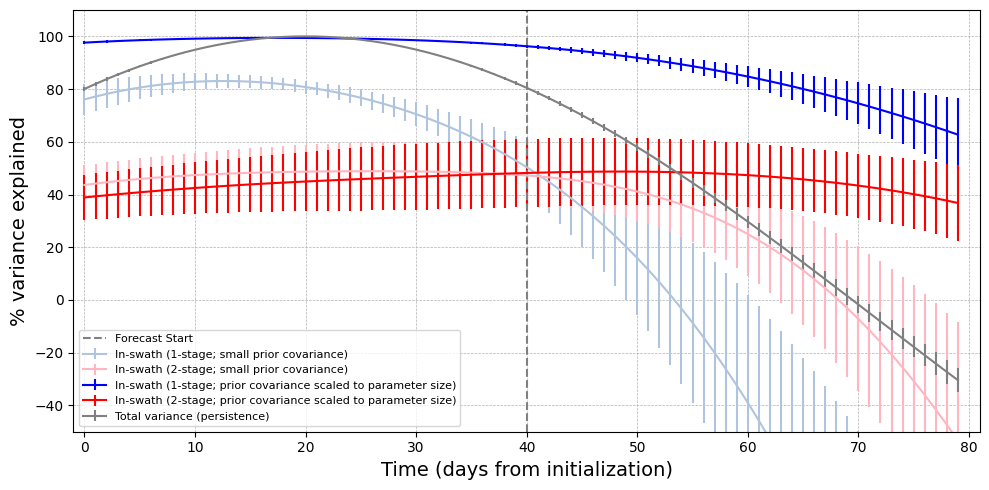

In [123]:
# Figure 8:  Fraction of SSH variance explained as a function of time, in-swath and out-of-swath
# Set figure size and aspect ratio for landscape orientation
fig, ax = plt.subplots(figsize=(10, 5))
# from alpha_std, choose the error amplitude to be plotted here
ialpha=0

# Define a color sequence for lines for better visibility and differentiation
colors = ['blue', 'orange', 'red', 'purple', 'brown', 'pink', 'gray', 'cyan', 'olive', 'navy', 'magenta','lightsteelblue','lightpink']

# Line plots
ax.errorbar(range(time_range), (1- variance_explained_in_1step[:,ialpha,:].mean(axis=0))*100, yerr=100*variance_explained_in_1step[:,ialpha,:].std(axis=0)/np.sqrt(nfiles), label='In-swath (1-stage; small prior covariance)', elinewidth=1.5, color=colors[11])
ax.errorbar(range(time_range), (1-variance_explained_in_2step[:,ialpha,:].mean(axis=0))*100, yerr=100*variance_explained_in_2step[:,ialpha,:].std(axis=0)/np.sqrt(nfiles), label='In-swath (2-stage; small prior covariance)', elinewidth=1.5, color=colors[12])
ialpha = 1
ax.errorbar(range(time_range), (1- variance_explained_in_1step[:,ialpha,:].mean(axis=0))*100, yerr=100*variance_explained_in_1step[:,ialpha,:].std(axis=0)/np.sqrt(nfiles), label='In-swath (1-stage; prior covariance scaled to parameter size)', ls='-', elinewidth=1.5, color=colors[0])
ax.errorbar(range(time_range), (1-variance_explained_in_2step[:,ialpha,:].mean(axis=0))*100, yerr=100*variance_explained_in_2step[:,ialpha,:].std(axis=0)/np.sqrt(nfiles), label='In-swath (2-stage; prior covariance scaled to parameter size)', ls='-', elinewidth=1.5, color=colors[2])
# ax.errorbar(range(time_range), (1-variance_explained_in_2stepa[:,ialpha,:].mean(axis=0))*100, yerr=100*variance_explained_in_2stepa[:,ialpha,:].std(axis=0)/np.sqrt(nfiles), label='In-swath variance (2-stage, augmented)', elinewidth=1.5, color=colors[10])
# ax.errorbar(range(time_range), (1-variance_explained_out_1step[:,ialpha,:].mean(axis=0))*100, yerr=100*variance_explained_out_1step[:,ialpha,:].std(axis=0)/np.sqrt(nfiles), label='Out-of-swath variance (1-stage)', elinewidth=1.5, color=colors[1])
# ax.errorbar(range(time_range), (1-variance_explained_out_2step[:,ialpha,:].mean(axis=0))*100, yerr=100*variance_explained_out_2step[:,ialpha,:].std(axis=0)/np.sqrt(nfiles), label='Out-of-swath variance (2-stage)', elinewidth=1.5, color=colors[3])
# ax.errorbar(range(time_range), (1-variance_explained_1step[:,ialpha,:].mean(axis=0))*100, yerr=100*variance_explained_1step[:,ialpha,:].std(axis=0)/np.sqrt(nfiles), label='Total variance (1-stage)', elinewidth=1.5, color=colors[8])
# ax.errorbar(range(time_range), (1-variance_explained_2step[:,ialpha,:].mean(axis=0))*100, yerr=100*variance_explained_2step[:,ialpha,:].std(axis=0)/np.sqrt(nfiles), label='Total variance (2-stage)', elinewidth=1.5, color=colors[9])
# #ax.errorbar(range(time_range), (1- variance_explained_in_persistence[:,ialpha,:].mean(axis=0))*100, yerr=100*variance_explained_in_persistence[:,ialpha,:].std(axis=0)/np.sqrt(nfiles), label='In-swath variance (persistence)', elinewidth=1.5, color=colors[4])
#ax.errorbar(range(time_range), (1-variance_explained_out_persistence[:,ialpha,:].mean(axis=0))*100, yerr=100*variance_explained_out_persistence[:,ialpha,:].std(axis=0)/np.sqrt(nfiles), label='Out-of-swath variance (persistence)', elinewidth=1.5, color=colors[5])
ax.errorbar(range(time_range), (1-variance_explained_persistence[:,ialpha,:].mean(axis=0))*100, yerr=100*variance_explained_persistence[:,ialpha,:].std(axis=0)/np.sqrt(nfiles), label='Total variance (persistence)', elinewidth=1.5, color=colors[6])
# Dashed vertical line at x = 40
ax.axvline(time_range//2, color='gray', linestyle='--', label="Forecast Start")
ax.set_ylim(bottom=-50,top=110)
ax.set_xlim(left=-1,right=81)
ax.grid(False)

# Adjust plot properties for better clarity
ax.set_xlabel('Time (days from initialization)', fontsize=14)
ax.set_ylabel('% variance explained', fontsize=14)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust legend position and size
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
ax.legend( fontsize=8)
plt.tight_layout()
plt.savefig('explained_variance1_simulator.png', dpi=300)
plt.show()

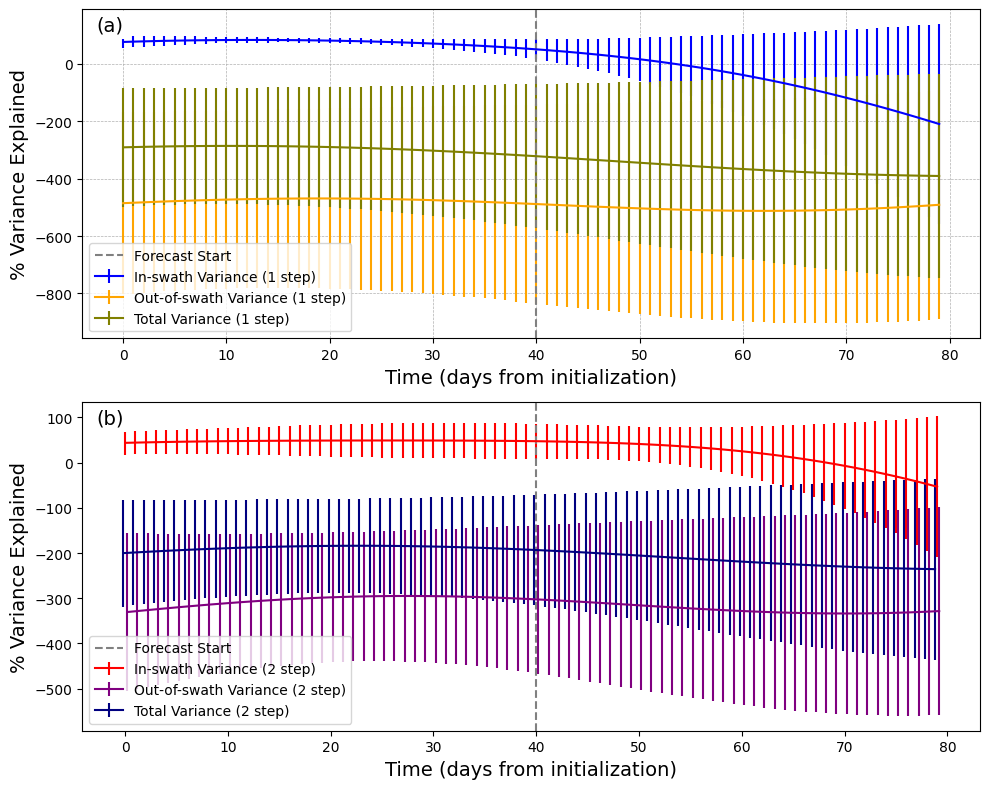

In [69]:
# Figure 8:  
# Set figure size and aspect ratio for landscape orientation
# fig, ax = plt.subplots(figsize=(10, 5))
import matplotlib.transforms as mtransforms
fig, ax = plt.subplots(2, figsize=(10, 8))
ialpha=0

# Define a color sequence for lines for better visibility and differentiation
colors = ['blue', 'orange', 'red', 'purple', 'brown', 'pink', 'gray', 'cyan', 'olive', 'navy']

# Line plots
ax[0].errorbar(range(time_range), (1- variance_explained_in_1step[:,ialpha,:].mean(axis=0))*100, yerr=100*variance_explained_in_1step[:,ialpha,:].std(axis=0), label='In-swath Variance (1 step)', elinewidth=1.5, color=colors[0])
ax[0].errorbar(range(time_range), (1-variance_explained_out_1step[:,ialpha,:].mean(axis=0))*100, yerr=100*variance_explained_out_1step[:,ialpha,:].std(axis=0), label='Out-of-swath Variance (1 step)', elinewidth=1.5, color=colors[1])
ax[1].errorbar(range(time_range), (1-variance_explained_in_2step[:,ialpha,:].mean(axis=0))*100, yerr=100*variance_explained_in_2step[:,ialpha,:].std(axis=0), label='In-swath Variance (2 step)', elinewidth=1.5, color=colors[2])
ax[1].errorbar(np.arange(0.2,0.2+time_range,1), (1-variance_explained_out_2step[:,ialpha,:].mean(axis=0))*100, yerr=100*variance_explained_out_2step[:,ialpha,:].std(axis=0), label='Out-of-swath Variance (2 step)', elinewidth=1.5, color=colors[3])
ax[0].errorbar(range(time_range), (1-variance_explained_1step[:,ialpha,:].mean(axis=0))*100, yerr=100*variance_explained_1step[:,ialpha,:].std(axis=0), label='Total Variance (1 step)', elinewidth=1.5, color=colors[8])
ax[1].errorbar(np.arange(-0.2,-0.2+time_range,1), (1-variance_explained_2step[:,ialpha,:].mean(axis=0))*100, yerr=100*variance_explained_2step[:,ialpha,:].std(axis=0), label='Total Variance (2 step)', elinewidth=1.5, color=colors[9])
# Dashed vertical line at x = 40
ax[0].axvline(time_range//2, color='gray', linestyle='--', label="Forecast Start")
ax[1].axvline(time_range//2, color='gray', linestyle='--', label="Forecast Start")

# Adjust plot properties for better clarity
# ax.set_title('SSH Variance Explained', fontsize=16, fontweight='bold')
ax[0].set_xlabel('Time (days from initialization)', fontsize=14)
ax[0].set_ylabel('% Variance Explained', fontsize=14)
ax[0].grid(True, which='both', linestyle='--', linewidth=0.5)

trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
ax[0].text(0.0, 1.0, '(a)', transform=ax[0].transAxes + trans,
            fontsize=14, verticalalignment='top', 
            bbox=dict(facecolor='1.0', edgecolor='none', pad=3.0))
            # bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
# ax[0].text(-5,100,'a')
# ax[0].text(.1,.9,'a test',transform=ax[0].transaxes)

# ax.set_title('SSH Variance Explained', fontsize=16, fontweight='bold')
ax[1].set_xlabel('Time (days from initialization)', fontsize=14)
ax[1].set_ylabel('% Variance Explained', fontsize=14)
# ax[1].grid(True, which='both', linestyle='--', linewidth=0.5)
ax[1].text(0.0, 1.0, '(b)', transform=ax[1].transAxes + trans,
            fontsize=14, verticalalignment='top', 
            bbox=dict(facecolor='1.0', edgecolor='none', pad=3.0))

# Adjust legend position and size
box = ax[0].get_position()
ax[0].set_position([box.x0, box.y0, box.width * 0.75, box.height])
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
ax[0].legend( fontsize=10)
# box = ax[1].get_position()
# ax[1].set_position([box.x1, box.y1, box.width * 0.75, box.height])
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
ax[1].legend( fontsize=10)
plt.tight_layout()
plt.savefig('explained_variance_'+ str(int((day1 - day0))) +'days_'+ str(R) + '_' + str(alpha_std[ialpha])[:6] + '_' + str(sigma_scale) +'.png', dpi=300)
plt.show()